# Bubble Shape of density by Combining Network
    
**Woojeong Kim** *8/20/2024*

   
 

In this notebook, we are going to combine different two networks to apply the adaptive time marching strategy in the paper [1]. To describe in detail for this strategy, by discretizing time domain evenly, one network simulate PDE system on a time period and the next similar but different network simulate successively from the ending point of the former network. Therefore, as the name of itself, this strategy is applying simulation adaptively by marching on discretized time domain.

On our simulation, the first network on time \[0, .1\] is made with the loss function added up for the loss terms coming from initial configuration equations, boundary condition equations and the following NS PDE equations.(See [1])
$$
\rho (x) \left( \frac{\partial u}{\partial t} + u \cdot \nabla u \right) = - \nabla p +  \eta({\phi }) \Delta u + \rho (x) g \\[5pt]
		\nabla \cdot u = 0, \\[5pt]
		[u]|_\Gamma = 0, \\[5pt]
		[pI + \eta (\nabla u + (\nabla u)^T)]|_\Gamma \cdot n = \sigma_{DA} \kappa n \\[5pt]
$$
Next, second network on time \[.1, .2\] is made in the same way with the first network, except for the loss terms coming from initial configuration equations. To be specific, for this second network, initial configuration of time .1 comes from the outcome variables of the first network of its ending time after training the first network. Hence, what we need to be careful is difference in first configuration of each network.

In the next paragraphs, there are three graphs. The first one is outcome variable of density of the first network on the ending time t=.1. So it has bubble shape rising from the initial circlular bubble at t=0.
By using this, for defining initial condition loss term of the second network, we can make use of initial configuration condition defined as the outcome variables of the first network at time t=.1. So for the second graph and third graph, we can see the bubble shape of density as the density outcome variable of the second network at time t=.1 and t=.2 each.


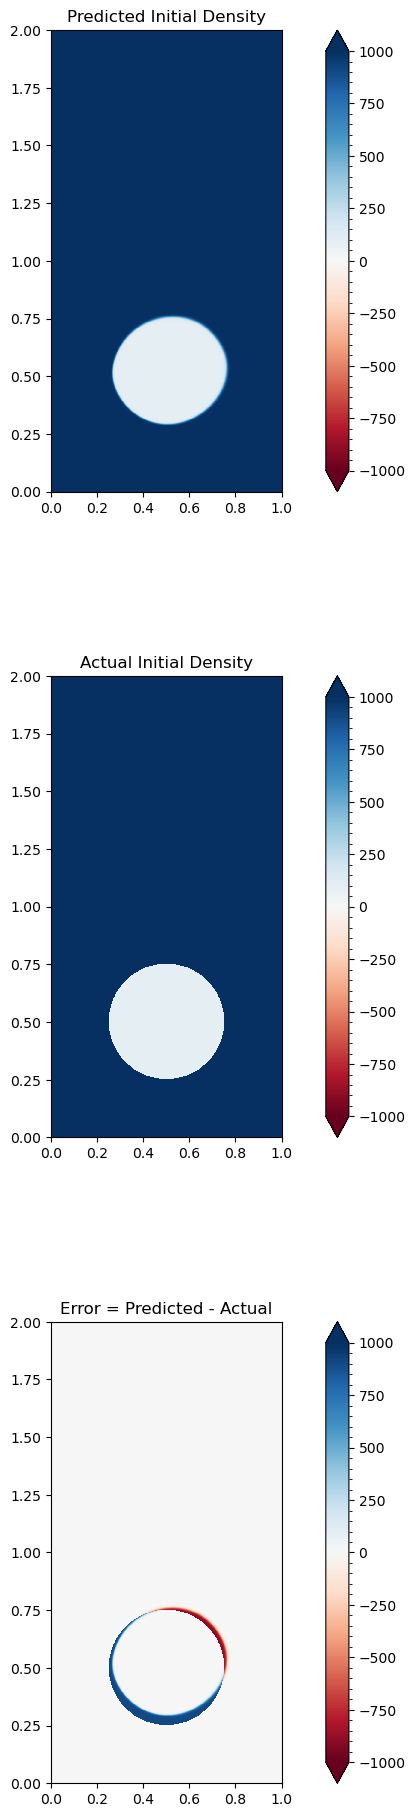

In [2]:
import torch
from torch import nn
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt

from Dummy_Layer_Setting import Dummy_Net
from InitialConditionLoss import InitialCondition_phi

###########################################

time_plotted = 0.1

###########################################

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Dummy_Net() #.to(device)

net.load_state_dict(torch.load("ES_min_loss_lr1e-07_t0.1_8_16_17h.pt")) #, map_location=torch.device('cpu')
'''
Iteration: 8500 	Total Loss: tensor(6.3190)
IC Loss:  tensor(0.0031) 	u BC Loss:  tensor(0.0063) 	phi BC Loss:  tensor(1.2028e-06) 	mu BC Loss:  tensor(0.0032) 	NS PDE Loss:  tensor(0.0201) 	NS Div Free Loss:  tensor(1.3087e-06) 	CH Loss:  tensor(0.0001) 	CH mu Loss:  tensor(0.0005)
  *Saved ; Early Stopping for the latest NS PDE Loss of 2nd decimal place

  *Saved ; Early Stopping for the latest IC Loss of 3rd decimal place

  *Saved ; Early Stopping for the latest NS Loss of 2nd decimal place and IC Loss of 3rd decimal place

  *Saved ; Early Stopping for the Minimal Total Loss
'''

#Graph at various time slices

spatial_discretization = 1000

#Define numpy arrays for inputs
x1 = np.linspace(net.x1_l,net.x1_u,spatial_discretization).reshape(spatial_discretization)
x2 = np.linspace(net.x2_l,net.x2_u,spatial_discretization).reshape(spatial_discretization)
x1x2 = np.array(np.meshgrid(x1, x2)).reshape(2,spatial_discretization**2)

t = time_plotted*np.ones((spatial_discretization**2,1))

x1_input = x1x2[0].reshape(spatial_discretization**2, 1)
x2_input = x1x2[1].reshape(spatial_discretization**2, 1)

x1x2 = [x1_input, x2_input]

#convert to pytorch tensors
pt_x1 = Variable(torch.from_numpy(x1_input).float(), requires_grad=True) #.to(device)
pt_x2 = Variable(torch.from_numpy(x2_input).float(), requires_grad=True) #.to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True) #.to(device)

#get network outputs
pt_u1, pt_u2, pt_P, pt_phi, pt_m_D = net(pt_x1, pt_x2, pt_t)


#get actual initial condition
phi_exact = InitialCondition_phi(net, pt_x1, pt_x2)
rho_exact = (1 - phi_exact)/2 *net.rho_1 + (1 + phi_exact)/2 *net.rho_2



#Convert back to numpy
u1, u2, P, phi, m_D = pt_u1.data.cpu().numpy(), pt_u2.data.cpu().numpy(), pt_P.data.cpu().numpy(), pt_phi.data.cpu().numpy(), pt_m_D.data.cpu().numpy()
rho = (1 - phi)/2 *net.rho_1 + (1 + phi)/2 *net.rho_2

rho_exact = rho_exact.data.cpu().numpy()
error = rho-rho_exact

X, Y = np.meshgrid(x1, x2)



fig, axs = plt.subplots(3 )
#fig.suptitle(f'Time = {time_plotted}')
fig.tight_layout()
axs[0].set_title('Predicted Initial Density')
axs[1].set_title('Actual Initial Density')
axs[2].set_title('Error = Predicted - Actual')
#axs[0].pcolor(X, Y, rho.reshape(X.shape))
#axs[1].pcolor(X, Y, rho_exact.reshape(X.shape))
#axs[2].pcolor(X, Y, error.reshape(X.shape))

# Plot both positive and negative values between +/- 1.2
pos_neg_clipped = axs[0].imshow(rho.reshape(X.shape), cmap='RdBu', vmin=-1000, vmax=1000,
                             interpolation='none', extent = (net.x1_l,net.x1_u, net.x2_u, net.x2_l))
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar = fig.colorbar(pos_neg_clipped, ax=axs[0].invert_yaxis(), extend='both')
cbar.minorticks_on()

# Plot both positive and negative values between +/- 1.2
pos_neg_clipped = axs[1].imshow(rho_exact.reshape(X.shape), cmap='RdBu', vmin=-1000, vmax=1000,
                             interpolation='none', extent = (net.x1_l,net.x1_u, net.x2_u, net.x2_l))
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar = fig.colorbar(pos_neg_clipped, ax=axs[1].invert_yaxis(), extend='both')
cbar.minorticks_on()

# Plot both positive and negative values between +/- 1000
pos_neg_clipped = axs[2].imshow(error.reshape(X.shape), cmap='RdBu', vmin=-1000, vmax=1000,
                             interpolation='none', extent = (net.x1_l,net.x1_u, net.x2_u, net.x2_l))
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar = fig.colorbar(pos_neg_clipped, ax=axs[2].invert_yaxis(), extend='both')
cbar.minorticks_on()

#plt.xticks(np.arange(0, 1, step=.1))
#plt.yticks(np.arange(0, 2, step=.1))

#axs[2].legend()
fig.set_figheight(20)
fig.set_figwidth(10)

plt.show()

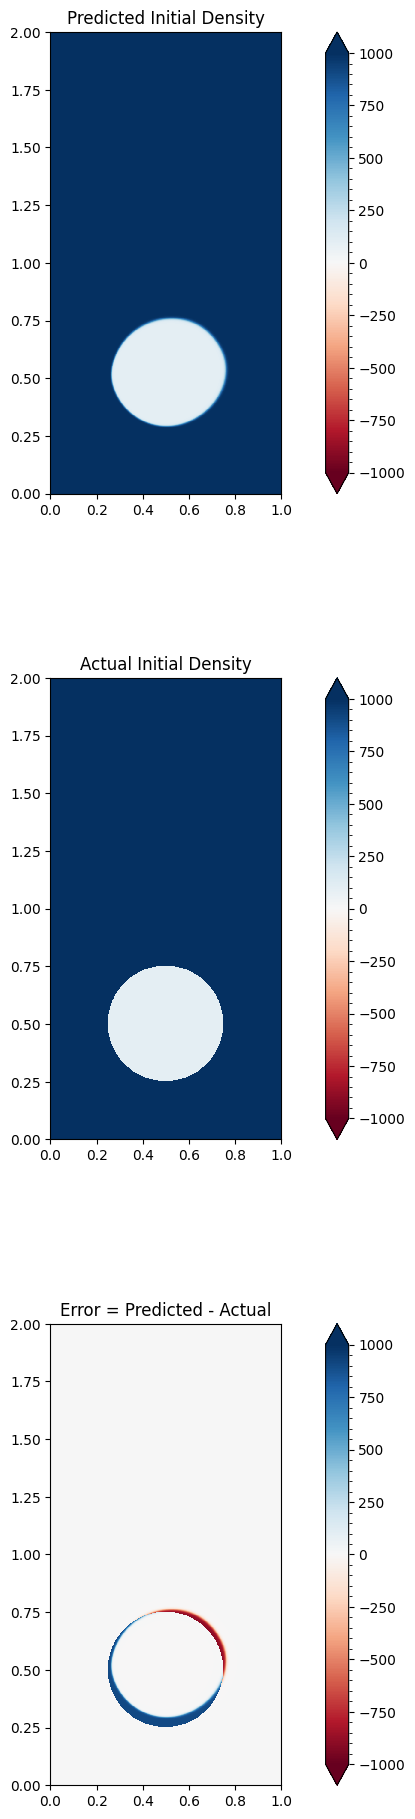

In [7]:
import torch
from torch import nn
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt

from Dummy_Layer_Setting import Dummy_Net
from InitialConditionLoss import InitialCondition_phi

###########################################

time_plotted = 0.1

###########################################

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Dummy_Net() #.to(device)

net.load_state_dict(torch.load("ES_min_loss_lr1e-07_t0.2_8_19_15h_Net2.pt")) #, map_location=torch.device('cpu')
'''
Iteration: 58000 	Total Loss: tensor(10.9114, device='cuda:0')
IC Loss:  tensor(0.0052, device='cuda:0') 	u BC Loss:  tensor(0.0409, device='cuda:0') 	phi BC Loss:  tensor(5.3659e-09, device='cuda:0') 	mu BC Loss:  tensor(0.0013, device='cuda:0') 	NS PDE Loss:  tensor(0.0050, device='cuda:0') 	NS Div Free Loss:  tensor(9.7927e-05, device='cuda:0') 	CH Loss:  tensor(0.0002, device='cuda:0') 	CH mu Loss:  tensor(0.0016, device='cuda:0')
  *Saved ; Early Stopping for the latest NS PDE Loss of 3rd decimal place

  *Saved ; Early Stopping for the latest IC Loss of 3rd decimal place

  *Saved ; Early Stopping for the latest NS Loss of 2nd decimal place and IC Loss of 3rd decimal place

  *Saved ; Early Stopping for the Minimal Total Loss
'''

#Graph at various time slices

spatial_discretization = 1000

#Define numpy arrays for inputs
x1 = np.linspace(net.x1_l,net.x1_u,spatial_discretization).reshape(spatial_discretization)
x2 = np.linspace(net.x2_l,net.x2_u,spatial_discretization).reshape(spatial_discretization)
x1x2 = np.array(np.meshgrid(x1, x2)).reshape(2,spatial_discretization**2)

t = time_plotted*np.ones((spatial_discretization**2,1))

x1_input = x1x2[0].reshape(spatial_discretization**2, 1)
x2_input = x1x2[1].reshape(spatial_discretization**2, 1)

x1x2 = [x1_input, x2_input]

#convert to pytorch tensors
pt_x1 = Variable(torch.from_numpy(x1_input).float(), requires_grad=True) #.to(device)
pt_x2 = Variable(torch.from_numpy(x2_input).float(), requires_grad=True) #.to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True) #.to(device)

#get network outputs
pt_u1, pt_u2, pt_P, pt_phi, pt_m_D = net(pt_x1, pt_x2, pt_t)


#get actual initial condition
phi_exact = InitialCondition_phi(net, pt_x1, pt_x2)
rho_exact = (1 - phi_exact)/2 *net.rho_1 + (1 + phi_exact)/2 *net.rho_2



#Convert back to numpy
u1, u2, P, phi, m_D = pt_u1.data.cpu().numpy(), pt_u2.data.cpu().numpy(), pt_P.data.cpu().numpy(), pt_phi.data.cpu().numpy(), pt_m_D.data.cpu().numpy()
rho = (1 - phi)/2 *net.rho_1 + (1 + phi)/2 *net.rho_2

rho_exact = rho_exact.data.cpu().numpy()
error = rho-rho_exact

X, Y = np.meshgrid(x1, x2)



fig, axs = plt.subplots(3 )
#fig.suptitle(f'Time = {time_plotted}')
fig.tight_layout()
axs[0].set_title('Predicted Initial Density')
axs[1].set_title('Actual Initial Density')
axs[2].set_title('Error = Predicted - Actual')
#axs[0].pcolor(X, Y, rho.reshape(X.shape))
#axs[1].pcolor(X, Y, rho_exact.reshape(X.shape))
#axs[2].pcolor(X, Y, error.reshape(X.shape))

# Plot both positive and negative values between +/- 1.2
pos_neg_clipped = axs[0].imshow(rho.reshape(X.shape), cmap='RdBu', vmin=-1000, vmax=1000,
                             interpolation='none', extent = (net.x1_l,net.x1_u, net.x2_u, net.x2_l))
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar = fig.colorbar(pos_neg_clipped, ax=axs[0].invert_yaxis(), extend='both')
cbar.minorticks_on()

# Plot both positive and negative values between +/- 1.2
pos_neg_clipped = axs[1].imshow(rho_exact.reshape(X.shape), cmap='RdBu', vmin=-1000, vmax=1000,
                             interpolation='none', extent = (net.x1_l,net.x1_u, net.x2_u, net.x2_l))
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar = fig.colorbar(pos_neg_clipped, ax=axs[1].invert_yaxis(), extend='both')
cbar.minorticks_on()

# Plot both positive and negative values between +/- 1000
pos_neg_clipped = axs[2].imshow(error.reshape(X.shape), cmap='RdBu', vmin=-1000, vmax=1000,
                             interpolation='none', extent = (net.x1_l,net.x1_u, net.x2_u, net.x2_l))
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar = fig.colorbar(pos_neg_clipped, ax=axs[2].invert_yaxis(), extend='both')
cbar.minorticks_on()

#plt.xticks(np.arange(0, 1, step=.1))
#plt.yticks(np.arange(0, 2, step=.1))

#axs[2].legend()
fig.set_figheight(20)
fig.set_figwidth(10)

plt.show()

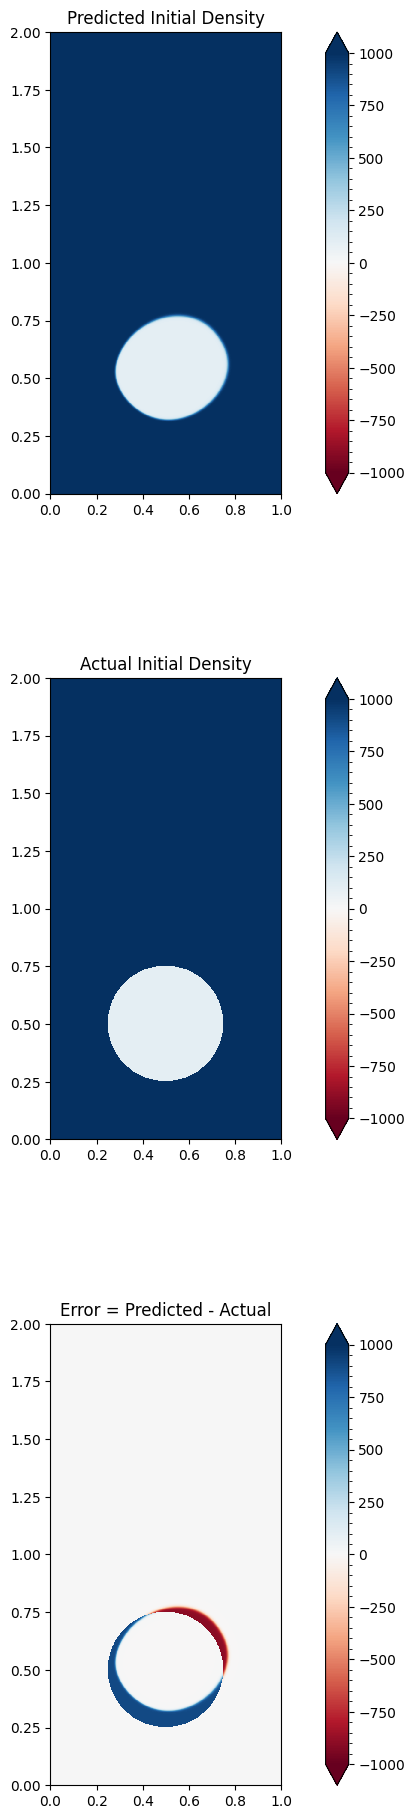

In [8]:
import torch
from torch import nn
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt

from Dummy_Layer_Setting import Dummy_Net
from InitialConditionLoss import InitialCondition_phi

###########################################

time_plotted = 0.2

###########################################

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Dummy_Net() #.to(device)

net.load_state_dict(torch.load("ES_min_loss_lr1e-07_t0.2_8_19_15h_Net2.pt")) #, map_location=torch.device('cpu')
'''
Iteration: 58000 	Total Loss: tensor(10.9114, device='cuda:0')
IC Loss:  tensor(0.0052, device='cuda:0') 	u BC Loss:  tensor(0.0409, device='cuda:0') 	phi BC Loss:  tensor(5.3659e-09, device='cuda:0') 	mu BC Loss:  tensor(0.0013, device='cuda:0') 	NS PDE Loss:  tensor(0.0050, device='cuda:0') 	NS Div Free Loss:  tensor(9.7927e-05, device='cuda:0') 	CH Loss:  tensor(0.0002, device='cuda:0') 	CH mu Loss:  tensor(0.0016, device='cuda:0')
  *Saved ; Early Stopping for the latest NS PDE Loss of 3rd decimal place

  *Saved ; Early Stopping for the latest IC Loss of 3rd decimal place

  *Saved ; Early Stopping for the latest NS Loss of 2nd decimal place and IC Loss of 3rd decimal place

  *Saved ; Early Stopping for the Minimal Total Loss
'''

#Graph at various time slices

spatial_discretization = 1000

#Define numpy arrays for inputs
x1 = np.linspace(net.x1_l,net.x1_u,spatial_discretization).reshape(spatial_discretization)
x2 = np.linspace(net.x2_l,net.x2_u,spatial_discretization).reshape(spatial_discretization)
x1x2 = np.array(np.meshgrid(x1, x2)).reshape(2,spatial_discretization**2)

t = time_plotted*np.ones((spatial_discretization**2,1))

x1_input = x1x2[0].reshape(spatial_discretization**2, 1)
x2_input = x1x2[1].reshape(spatial_discretization**2, 1)

x1x2 = [x1_input, x2_input]

#convert to pytorch tensors
pt_x1 = Variable(torch.from_numpy(x1_input).float(), requires_grad=True) #.to(device)
pt_x2 = Variable(torch.from_numpy(x2_input).float(), requires_grad=True) #.to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True) #.to(device)

#get network outputs
pt_u1, pt_u2, pt_P, pt_phi, pt_m_D = net(pt_x1, pt_x2, pt_t)


#get actual initial condition
phi_exact = InitialCondition_phi(net, pt_x1, pt_x2)
rho_exact = (1 - phi_exact)/2 *net.rho_1 + (1 + phi_exact)/2 *net.rho_2



#Convert back to numpy
u1, u2, P, phi, m_D = pt_u1.data.cpu().numpy(), pt_u2.data.cpu().numpy(), pt_P.data.cpu().numpy(), pt_phi.data.cpu().numpy(), pt_m_D.data.cpu().numpy()
rho = (1 - phi)/2 *net.rho_1 + (1 + phi)/2 *net.rho_2

rho_exact = rho_exact.data.cpu().numpy()
error = rho-rho_exact

X, Y = np.meshgrid(x1, x2)



fig, axs = plt.subplots(3 )
#fig.suptitle(f'Time = {time_plotted}')
fig.tight_layout()
axs[0].set_title('Predicted Initial Density')
axs[1].set_title('Actual Initial Density')
axs[2].set_title('Error = Predicted - Actual')
#axs[0].pcolor(X, Y, rho.reshape(X.shape))
#axs[1].pcolor(X, Y, rho_exact.reshape(X.shape))
#axs[2].pcolor(X, Y, error.reshape(X.shape))

# Plot both positive and negative values between +/- 1.2
pos_neg_clipped = axs[0].imshow(rho.reshape(X.shape), cmap='RdBu', vmin=-1000, vmax=1000,
                             interpolation='none', extent = (net.x1_l,net.x1_u, net.x2_u, net.x2_l))
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar = fig.colorbar(pos_neg_clipped, ax=axs[0].invert_yaxis(), extend='both')
cbar.minorticks_on()

# Plot both positive and negative values between +/- 1.2
pos_neg_clipped = axs[1].imshow(rho_exact.reshape(X.shape), cmap='RdBu', vmin=-1000, vmax=1000,
                             interpolation='none', extent = (net.x1_l,net.x1_u, net.x2_u, net.x2_l))
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar = fig.colorbar(pos_neg_clipped, ax=axs[1].invert_yaxis(), extend='both')
cbar.minorticks_on()

# Plot both positive and negative values between +/- 1000
pos_neg_clipped = axs[2].imshow(error.reshape(X.shape), cmap='RdBu', vmin=-1000, vmax=1000,
                             interpolation='none', extent = (net.x1_l,net.x1_u, net.x2_u, net.x2_l))
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar = fig.colorbar(pos_neg_clipped, ax=axs[2].invert_yaxis(), extend='both')
cbar.minorticks_on()

#plt.xticks(np.arange(0, 1, step=.1))
#plt.yticks(np.arange(0, 2, step=.1))

#axs[2].legend()
fig.set_figheight(20)
fig.set_figwidth(10)

plt.show()

## Reference

[comment]: # (If this work is helpful, please cite as:)

<a id="1">[1]</a> 
S. Hysing,
S. Turek,
D. Kuzmin,
N. Parolini, E. Burman,
S. Ganesank, and L. Tobiska, 
Proposal for quantitative benchmark
computations of bubble dynamics, 
Ergebnisberichte des Instituts für Angewandte Mathematik, Nummer
351, Fakultät für Mathematik, TU Dortmund, 2007.